In [1]:
#https://www.kaggle.com/datasets/tongpython/cat-and-dog

In [2]:
#!gdown --id  1detGLQxIBNauJmDZ64bpcOFr-VhCIToc
#!unzip  cat-and-dog.zip

In [3]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.1.0+cu118'

In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Chargement de l'ensemble de données

Le jeu de données que nous allons utiliser pour ce tutoriel est le jeu de données cat and dog, qui contient des images de chats et de chiens. Jetons un coup d'œil aux fichiers contenus dans le dossier dataset. Pour ce faire, je vais créer une fonction.

In [5]:
import os
import glob
import random
import numpy as np
import seaborn as sns
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

In [6]:
import torchvision.models as models

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
image_path="cat-and-dog"
train_dir = "cat-and-dog/training_set/training_set"
test_dir = "cat-and-dog/test_set/test_set"
train_dir, test_dir

('cat-and-dog/training_set/training_set', 'cat-and-dog/test_set/test_set')

# Comprendre l'ensemble des données

It is important to understand the dataset for deep learning analysis because the dataset is the foundation of any machine learning or deep learning model. A deep learning model can only be as good as the data it is trained on, and a poor understanding of the dataset can lead to poor model performance or even bias. Now let's take a look at an image in the dataset.

Random image path: cat-and-dog/test_set/test_set/dogs/dog.4741.jpg
Image class: dogs
Image height: 375
Image width: 499


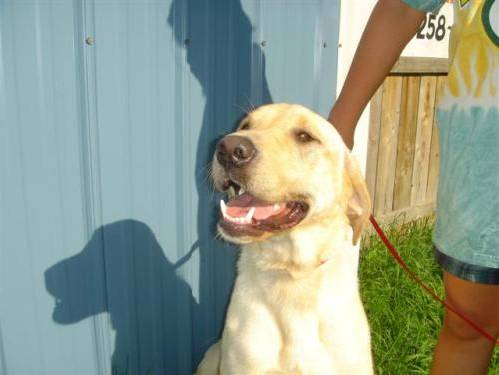

In [9]:


# Set seed
random.seed(42)

# 1. Obtenir tous les chemins d'accès aux images (* signifie "toute combinaison")
image_path_list= glob.glob(f"{image_path}/*/*/*/*.jpg")

# 2. Obtenir un chemin d'accès aléatoire à l'image
random_image_path = random.choice(image_path_list)

# 3. Obtenir la classe d'image à partir du nom du chemin (la classe d'image est le nom du répertoire dans lequel l'image est stockée)
image_class = Path(random_image_path).parent.stem

# 4. Ouvrir l'image
img = Image.open(random_image_path)

# 5. Imprimer les métadonnées
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

# Transformer les données

La transformation des données, également connue sous le nom de prétraitement, est une étape importante dans l'analyse de l'apprentissage profond car elle peut aider à améliorer les performances du modèle et à réduire le risque de biais. Jouons un peu avec les images grâce à la méthode `transform`.

In [10]:

# Ecriture d'une transformation pour l'image
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Pour comprendre comment transformer les images, utilisons la visualisation des données. Pour ce faire, je vais créer une fonction appelée plot_transformed_images.

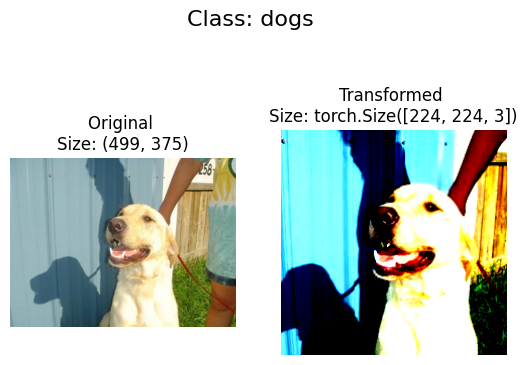

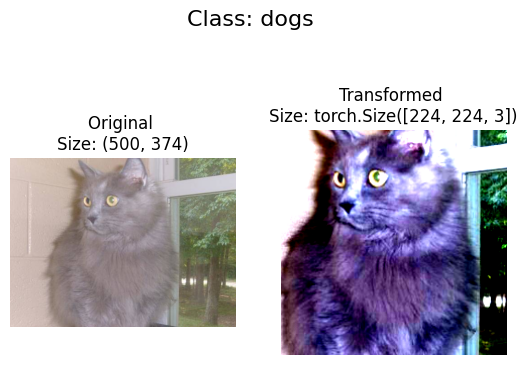

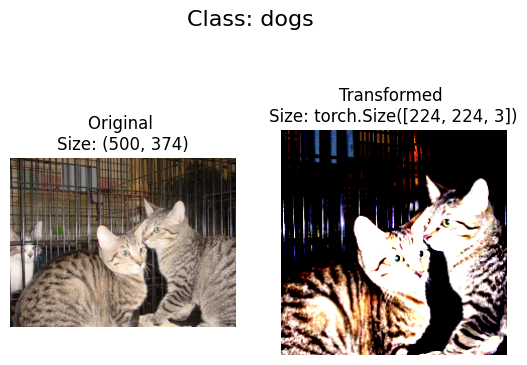

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transformer et tracer l'image
            # Note : permute() changera la forme de l'image pour l'adapter à matplotlib
            # (la valeur par défaut de PyTorch est [C, H, W] mais celle de Matplotlib est [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(random_image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)

# Chargement des données d'une image
Jusqu'à présent, nous avons créé une fonction de transformation de données. Nous sommes prêts à charger notre jeu de données à l'aide de cette fonction. La façon la plus simple de charger des données est d'utiliser la fonction `ImageFolder` de PyTorch. Chargeons le jeu de données avec cette fonction.

In [12]:
from torchvision import datasets

# Création d'un ensemble d'entraînement
train_data = datasets.ImageFolder(root=train_dir, # dossier cible des images
                                  transform=data_transform, # Transformations à effectuer sur les données (images)
                                  target_transform=None) # Transformations à effectuer sur les étiquettes (si nécessaire)
#Création d'une série de tests
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 8005
    Root location: cat-and-dog/training_set/training_set
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2023
    Root location: cat-and-dog/test_set/test_set
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


Découvrons maintenant l'ensemble de données à l'aide des attributs comme indiqué ci-dessous.

In [13]:
# Obtenir les noms des classes sous forme de liste
class_names = train_data.classes
print("Class names: ",class_names)
# Peut également obtenir les noms de classe sous forme de dict
class_dict = train_data.class_to_idx
print("Class names as a dict: ",class_dict)

# Vérifiez les longueurs
print("Longueur des ensembles d'apprentissage et de test: ", len(train_data), len(test_data))

Class names:  ['cats', 'dogs']
Class names as a dict:  {'cats': 0, 'dogs': 1}
Longueur des ensembles d'apprentissage et de test:  8005 2023


## Transformer les images chargées en images DataLoader

Jusqu'à présent, nous avons chargé des images. Notez qu'un `DataLoader` dans PyTorch est un utilitaire utilisé pour charger des données à partir d'un objet dataset en parallèle. Il permet à l'utilisateur de charger des données par lots, ce qui peut être utile pour la formation des modèles d'apprentissage profond, car cela permet au modèle de traiter plusieurs échantillons à la fois, ce qui peut accélérer le processus de formation. En outre, il permet également à l'utilisateur de mélanger les données, ce qui peut aider à prévenir le surajustement.

Le DataLoader prend un objet dataset et plusieurs autres paramètres optionnels, tels que la taille du lot, le nombre de threads de travail à utiliser pour charger les données et un drapeau booléen indiquant s'il faut ou non mélanger les données. Le DataLoader renvoie alors un itérateur qui peut être utilisé pour parcourir les données par lots.


In [14]:
# Transformez les ensembles de données d'entraînement et de test en DataLoaders

bs=128
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=bs,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=bs,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b4a08db78b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b4a08db73d0>)

In [15]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=2)
model=model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
for parma in model.parameters():
    parma.requires_grad = True

In [17]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
# Initialiser le modèle, la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


In [19]:
# Former le modèle
train_loss=[]
test_accuracy=[]
best_accuracy=-np.inf
num_epochs = 20
for epoch in range(num_epochs):

    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        running_loss += loss.item()
        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0
    train_loss.append(running_loss/(i+1))
    # Tester le modèle
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    test_accuracy.append(accuracy)
    print('Précision du réseau a lepoch %d sur les images tests:'%(epoch+1) ,100 * accuracy)
    if accuracy > best_accuracy:
      best_accuracy=accuracy
      torch.save(model.state_dict(), 'CNN.pth')



print('Formation terminée')

Epoch [1/20], Step [10/63], Loss: 0.1886
Epoch [1/20], Step [20/63], Loss: 0.0823
Epoch [1/20], Step [30/63], Loss: 0.0699
Epoch [1/20], Step [40/63], Loss: 0.0695
Epoch [1/20], Step [50/63], Loss: 0.0692
Epoch [1/20], Step [60/63], Loss: 0.0692
Précision du réseau a lepoch 1 sur les images tests: 50.024715768660414
Epoch [2/20], Step [10/63], Loss: 0.0701
Epoch [2/20], Step [20/63], Loss: 0.0699
Epoch [2/20], Step [30/63], Loss: 0.0707
Epoch [2/20], Step [40/63], Loss: 0.0717
Epoch [2/20], Step [50/63], Loss: 0.0689
Epoch [2/20], Step [60/63], Loss: 0.0708
Précision du réseau a lepoch 2 sur les images tests: 61.047948591201184
Epoch [3/20], Step [10/63], Loss: 0.0690
Epoch [3/20], Step [20/63], Loss: 0.0673
Epoch [3/20], Step [30/63], Loss: 0.0669
Epoch [3/20], Step [40/63], Loss: 0.0609
Epoch [3/20], Step [50/63], Loss: 0.0622
Epoch [3/20], Step [60/63], Loss: 0.0572
Précision du réseau a lepoch 3 sur les images tests: 69.30301532377658
Epoch [4/20], Step [10/63], Loss: 0.0558
Epoch 

KeyboardInterrupt: ignored

In [ ]:
#torch.save(model.state_dict(), 'CNN.pth')

In [20]:
model.load_state_dict(torch.load('CNN.pth'))

<All keys matched successfully>

In [21]:


# Tester le modèle
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        #print(outputs.shape)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Précision du réseau sur les images tests: {100 * accuracy:.2f}%')

Précision du réseau sur les images tests: 90.41%


#Tracer les vecteurs de caractéristiques à l'aide de TSNE

In [22]:
from sklearn.manifold import TSNE

In [23]:
last_layer_output = []
labels = []
with torch.no_grad():
        for data in test_dataloader:
            inputs, target = data
            inputs, target = inputs.cuda(), target.cuda()
            outputs = model.features(inputs)
            last_layer_output.extend(outputs.detach().cpu().numpy().reshape(len(outputs),-1))
            labels.extend(target.detach().cpu().numpy())

In [24]:
last_layer_output=np.array(last_layer_output)
labels =np.array(labels )

In [25]:
tsne = TSNE(n_components=2, random_state=42)
output_2d = tsne.fit_transform(last_layer_output)

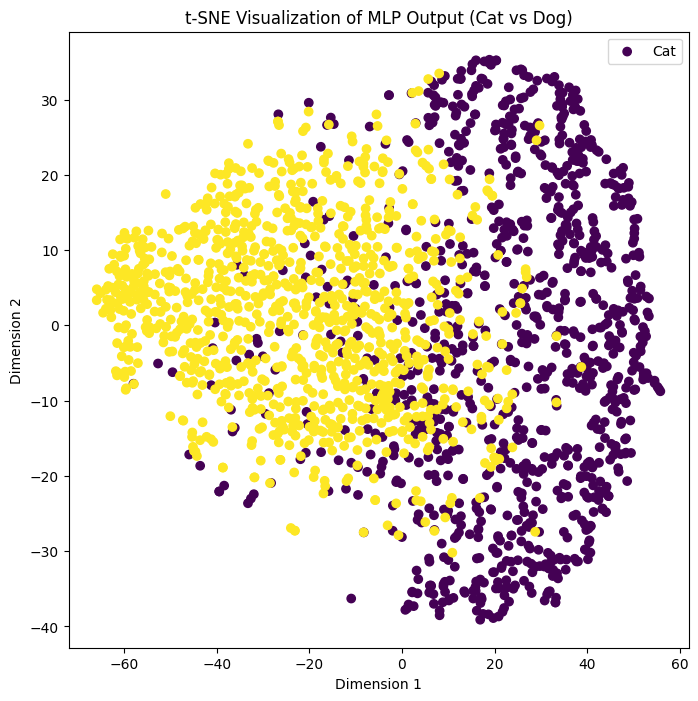

In [26]:
# Visualize the 2D representation of the validation set
plt.figure(figsize=(8, 8))
plt.scatter(output_2d[:, 0], output_2d[:, 1], c=labels)

plt.title('t-SNE Visualization of MLP Output (Cat vs Dog)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(['Cat', 'Dog'])
plt.show()